In [1]:
!pip install xlrd
!pip install plotnine
!pip install plotly
!pip install xlrd
!pip install scikit-learn
!pip install great-tables
!pip install polars



In [5]:
# # Introduction: function get_data:

import urllib
import urllib.request
import os
import zipfile
from urllib.request import Request, urlopen
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import sklearn


def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, "wb") as out_file:
            out_file.write(dl_file.read())


def create_votes_dataframes():

    Path("data").mkdir(parents=True, exist_ok=True)

    download_url(
        "https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_county_20m.zip",
        "data/shapefile",
    )
    with zipfile.ZipFile("data/shapefile", "r") as zip_ref:
        zip_ref.extractall("data/counties")

    shp = gpd.read_file("data/counties/cb_2019_us_county_20m.shp")
    shp = shp[~shp["STATEFP"].isin(["02", "69", "66", "78", "60", "72", "15"])]
    shp

    df_election = pd.read_csv(
        "https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2020_US_County_Level_Presidential_Results.csv"
    )
    df_election.head(2)
    population = pd.read_excel(
        "https://www.ers.usda.gov/webdocs/DataFiles/48747/PopulationEstimates.xls?v=290.4",
        header=2,
    ).rename(columns={"FIPStxt": "FIPS"})
    education = pd.read_excel(
        "https://www.ers.usda.gov/webdocs/DataFiles/48747/Education.xls?v=290.4",
        header=4,
    ).rename(columns={"FIPS Code": "FIPS", "Area name": "Area_Name"})
    unemployment = pd.read_excel(
        "https://www.ers.usda.gov/webdocs/DataFiles/48747/Unemployment.xls?v=290.4",
        header=4,
    ).rename(columns={"fips_txt": "FIPS", "area_name": "Area_Name", "Stabr": "State"})
    income = pd.read_excel(
        "https://www.ers.usda.gov/webdocs/DataFiles/48747/PovertyEstimates.xls?v=290.4",
        header=4,
    ).rename(columns={"FIPStxt": "FIPS", "Stabr": "State", "Area_name": "Area_Name"})

    dfs = [
        df.set_index(["FIPS", "State"])
        for df in [population, education, unemployment, income]
    ]
    data_county = pd.concat(dfs, axis=1)
    df_election = df_election.merge(
        data_county.reset_index(), left_on="county_fips", right_on="FIPS"
    )
    df_election["county_fips"] = df_election["county_fips"].astype(str).str.lstrip("0")
    shp["FIPS"] = shp["GEOID"].astype(str).str.lstrip("0")
    votes = shp.merge(df_election, left_on="FIPS", right_on="county_fips")

    req = Request(
        "https://dataverse.harvard.edu/api/access/datafile/3641280?gbrecs=false"
    )
    req.add_header(
        "User-Agent",
        "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0",
    )
    content = urlopen(req)
    df_historical = pd.read_csv(content, sep="\t")
    # df_historical = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3641280?gbrecs=false', sep = "\t")

    df_historical = df_historical.dropna(subset=["FIPS"])
    df_historical["FIPS"] = df_historical["FIPS"].astype(int)
    df_historical["share"] = (
        df_historical["candidatevotes"] / df_historical["totalvotes"]
    )
    df_historical = df_historical[["year", "FIPS", "party", "candidatevotes", "share"]]
    df_historical["party"] = df_historical["party"].fillna("other")

    df_historical_wide = df_historical.pivot_table(
        index="FIPS", values=["candidatevotes", "share"], columns=["year", "party"]
    )
    df_historical_wide.columns = [
        "_".join(map(str, s)) for s in df_historical_wide.columns.values
    ]
    df_historical_wide = df_historical_wide.reset_index()
    df_historical_wide["FIPS"] = df_historical_wide["FIPS"].astype(str).str.lstrip("0")
    votes["FIPS"] = votes["GEOID"].astype(str).str.lstrip("0")
    votes = votes.merge(df_historical_wide, on="FIPS")
    votes["winner"] = np.where(
        votes["votes_gop"] > votes["votes_dem"], "republican", "democrats"
    )

    return votes



In [2]:
df_votes = create_votes_dataframes()
df_votes.head()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME LSAD  \
0      29      227  00758566  0500000US29227  29227       Worth   06   
1      31      061  00835852  0500000US31061  31061    Franklin   06   
2      36      013  00974105  0500000US36013  36013  Chautauqua   06   
3      37      181  01008591  0500000US37181  37181       Vance   06   
4      47      183  01639799  0500000US47183  47183     Weakley   06   

        ALAND      AWATER                                           geometry  \
0   690564983      493903  POLYGON ((-94.63203 40.57176, -94.53388 40.570...   
1  1491355860      487899  POLYGON ((-99.1794 40.35068, -98.72683 40.3504...   
2  2746047476  1139407865  POLYGON ((-79.76195 42.26986, -79.62748 42.324...   
3   653713542    42178610  POLYGON ((-78.49773 36.51467, -78.45728 36.541...   
4  1503107848     3707114  POLYGON ((-88.94916 36.4101, -88.81642 36.4107...   

   ... share_2008_democrat share_2008_other share_2008_republican  \
0  ...            0.363714         0.034072              0.602215   
1  ...            0.284794         0.019974              0.695232   
2  ...            0.495627         0.018104              0.486269   
3  ...            0.630827         0.004743              0.364429   
4  ...            0.335720         0.017458              0.646822   

  share_2012_democrat  share_2012_other  share_2012_republican  \
0            0.325382          0.041031               0.633588   
1            0.250000          0.026042               0.723958   
2            0.425017          0.115852               0.459131   
3            0.638870          0.004891               0.356239   
4            0.287590          0.014914               0.697495   

   share_2016_democrat  share_2016_other  share_2016_republican      winner  
0             0.186424          0.041109               0.772467  republican  
1             0.149432          0.045427               0.805140  republican  
2             0.352012          0.065439               0.582550  republican  
3             0.612154          0.020824               0.367022   democrats  
4             0.227511          0.033158               0.739330  republican  

[5 rows x 383 columns]

In [2]:
# # Chargement de la fonction get_data (équivalent à 1ère cellule)

import requests

url = "https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py"
r = requests.get(url, allow_redirects=True)
open("getdata.py", "wb").write(r.content)

import getdata

votes = getdata.create_votes_dataframes()
votes.head()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME LSAD  \
0      29      227  00758566  0500000US29227  29227       Worth   06   
1      31      061  00835852  0500000US31061  31061    Franklin   06   
2      36      013  00974105  0500000US36013  36013  Chautauqua   06   
3      37      181  01008591  0500000US37181  37181       Vance   06   
4      47      183  01639799  0500000US47183  47183     Weakley   06   

        ALAND      AWATER                                           geometry  \
0   690564983      493903  POLYGON ((-94.63203 40.57176, -94.53388 40.570...   
1  1491355860      487899  POLYGON ((-99.1794 40.35068, -98.72683 40.3504...   
2  2746047476  1139407865  POLYGON ((-79.76195 42.26986, -79.62748 42.324...   
3   653713542    42178610  POLYGON ((-78.49773 36.51467, -78.45728 36.541...   
4  1503107848     3707114  POLYGON ((-88.94916 36.4101, -88.81642 36.4107...   

   ... share_2008_democrat share_2008_other share_2008_republican  \
0  ...            0.363714         0.034072              0.602215   
1  ...            0.284794         0.019974              0.695232   
2  ...            0.495627         0.018104              0.486269   
3  ...            0.630827         0.004743              0.364429   
4  ...            0.335720         0.017458              0.646822   

  share_2012_democrat  share_2012_other  share_2012_republican  \
0            0.325382          0.041031               0.633588   
1            0.250000          0.026042               0.723958   
2            0.425017          0.115852               0.459131   
3            0.638870          0.004891               0.356239   
4            0.287590          0.014914               0.697495   

   share_2016_democrat  share_2016_other  share_2016_republican      winner  
0             0.186424          0.041109               0.772467  republican  
1             0.149432          0.045427               0.805140  republican  
2             0.352012          0.065439               0.582550  republican  
3             0.612154          0.020824               0.367022   democrats  
4             0.227511          0.033158               0.739330  republican  

[5 rows x 383 columns]

In [15]:
# # Carte des vainqueurs:
import plotnine as p9
# from plotnine import ggplot, geom_map  #*

# republican : red, democrat : blue
color_dict = {"republican": "#FF0000", "democrats": "#0000FF"}

(
    p9.ggplot(votes)
    + p9.geom_map(p9.aes(fill="winner"))
    + p9.scale_fill_manual(color_dict)
    + p9.labs(fill="Winner")
    + p9.theme_void()
    + p9.theme(legend_position="bottom")
)

In [5]:
# # Carte interactive
import numpy as np
import pandas as pd
import geopandas as gpd
# import plotly
import plotly.graph_objects as go


centroids = votes.copy()
centroids.geometry = centroids.centroid
centroids["size"] = (
    centroids["CENSUS_2010_POP"] / 10000
)  # to get reasonable plotable number

color_dict = {"republican": "#FF0000", "democrats": "#0000FF"}
centroids["winner"] = np.where(
    centroids["votes_gop"] > centroids["votes_dem"], "republican", "democrats"
)


centroids["lon"] = centroids["geometry"].x
centroids["lat"] = centroids["geometry"].y
centroids = pd.DataFrame(
    centroids[["county_name", "lon", "lat", "winner", "CENSUS_2010_POP", "state_name"]]
)
groups = centroids.groupby("winner")

df = centroids.copy()

df["color"] = df["winner"].replace(color_dict)
df["size"] = df["CENSUS_2010_POP"] / 6000
df["text"] = (
    df["CENSUS_2010_POP"]
    .astype(int)
    .apply(lambda x: "<br>Population: {:,} people".format(x))
)
df["hover"] = (
    df["county_name"].astype(str)
    + df["state_name"].apply(lambda x: " ({}) ".format(x))
    + df["text"]
)

fig_plotly = go.Figure(
    data=go.Scattergeo(
        locationmode="USA-states",
        lon=df["lon"],
        lat=df["lat"],
        text=df["hover"],
        mode="markers",
        marker_color=df["color"],
        marker_size=df["size"],
        hoverinfo="text",
    )
)

fig_plotly.update_traces(
    marker={
        "opacity": 0.5,
        "line_color": "rgb(40,40,40)",
        "line_width": 0.5,
        "sizemode": "area",
    }
)

fig_plotly.update_layout(
    title_text='Reproduction of the "Acres don\'t vote, people do" map <br>(Click legend to toggle traces)',
    showlegend=True,
    geo={"scope": "usa", "landcolor": "rgb(217, 217, 217)"},
)

fig_plotly.show()

C:\Users\dmarin\AppData\Local\Temp\ipykernel_20436\3157590216.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



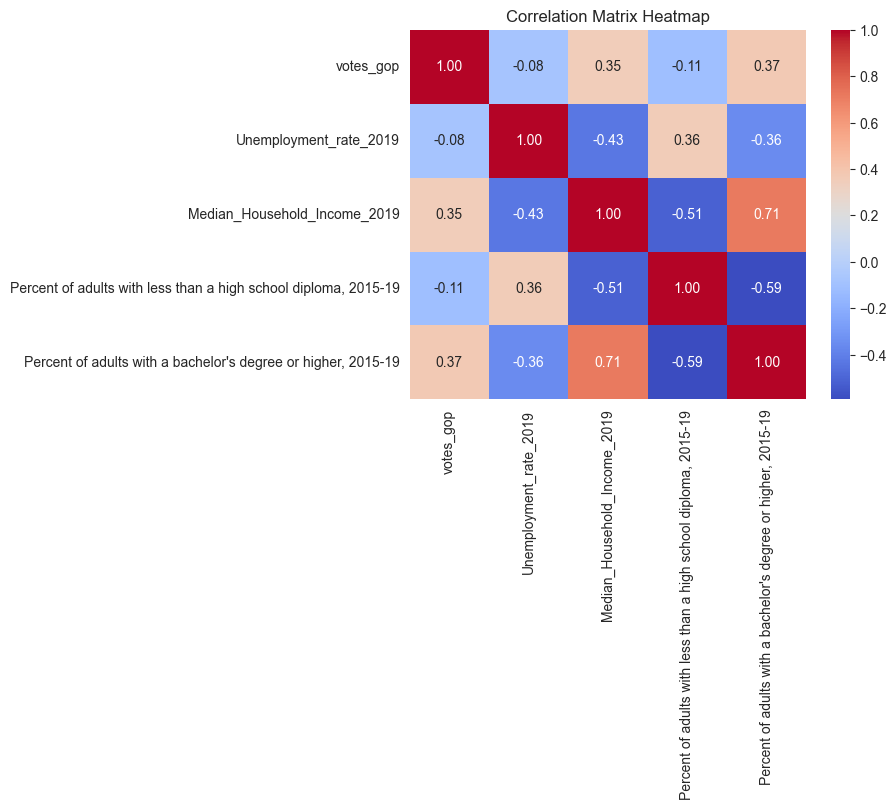

In [ ]:
# # Exercice 2: Corrélation entre variables explicatives du vote , on evite de mettre trop de variable fortement corrélés entre elles

import seaborn as sns
import matplotlib.pyplot as plt

df2 = votes.set_index("GEOID").loc[
    :,
    [
        "winner",
        "votes_gop",
        "Unemployment_rate_2019",
        "Median_Household_Income_2019",
        "Percent of adults with less than a high school diploma, 2015-19",
        "Percent of adults with a bachelor's degree or higher, 2015-19",
    ],
]

# # Matrice de corrélation avec seaborn
corr_mat = df2.loc[:, df2.columns != 'winner'].corr()
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Display the plot
plt.title("Correlation Matrix Heatmap")
plt.show()



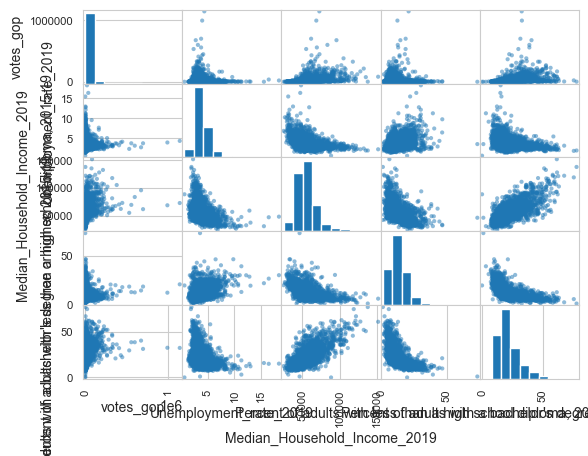

In [7]:
# # nuage de points:
pd.plotting.scatter_matrix(df2)
plt.show()

In [16]:
# # Exercice 3: standardisation des valeurs:

# # Visualisation de la distribution active:
(
    p9.ggplot(df2, p9.aes(x="Median_Household_Income_2019"))
    + p9.geom_histogram()
    + p9.labs(
        x="2019 Median household income (standardized)",
        y="Density (number observations)",
    )
)


C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 60'. Pick better value with 'binwidth'.


moy: 1.829527481841262e-16, std: 1.0001609657958113, variance: 1.0003219575016098


C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 60'. Pick better value with 'binwidth'.


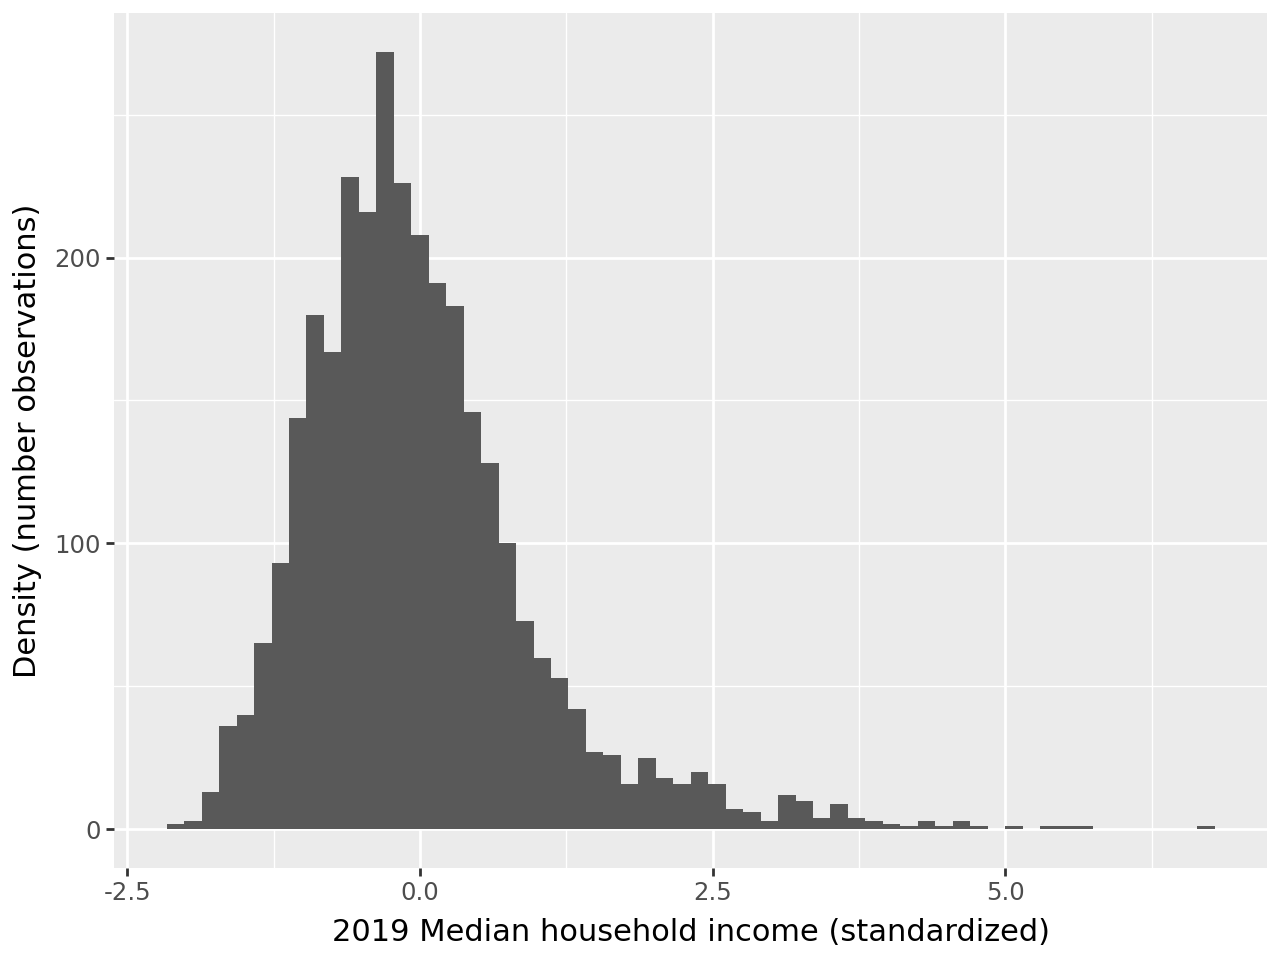

In [21]:
# # 3.1 Standardize the data:
# import matplotlib.pyplot as plt
from sklearn import preprocessing

df2["y_standard"] = preprocessing.scale(df2["Median_Household_Income_2019"])

# # Vérif et moyenne, variance:
print('moy: {}, variance: {}'.format(df2["y_standard"].mean(), df2["y_standard"].var()))

# # plot:
(
    p9.ggplot(df2, p9.aes(x="y_standard"))
    + p9.geom_histogram()
    + p9.labs(
        x="2019 Median household income (standardized)",
        y="Density (number observations)",
    )
)


In [27]:
# # Création d'un scaler

from great_tables import *

df_exo3 = df2.drop("winner", axis=1)

first_rows = df_exo3.head(1000)

mean_before = np.array(first_rows.mean(axis=0))
std_before = np.array(first_rows.std(axis=0))

# Initialize and apply the scaler
scaler = preprocessing.StandardScaler().fit(first_rows)
scaled_data = scaler.transform(first_rows)

mean_after = scaled_data.mean(axis=0)
std_after = scaled_data.std(axis=0)

# Create DataFrame to store results
result_df = pd.DataFrame(
    {
        "Variable": df_exo3.columns,
        "Mean before Scaling": mean_before,
        "Std before Scaling": std_before,
        "Mean after Scaling": mean_after,
        "Std after Scaling": std_after,
    }
)

print(result_df.describe().round())

(
    GT(result_df)
    .fmt_nanoplot("Mean before Scaling", options={"interactive_data_values": False})
    .fmt_nanoplot("Std before Scaling")
    .fmt_nanoplot("Mean after Scaling")
    .fmt_nanoplot("Std after Scaling")
)

       Mean before Scaling  Std before Scaling  Mean after Scaling  \
count                  6.0                 6.0                 6.0   
mean               12098.0              7693.0                 0.0   
std                22222.0             13410.0                 0.0   
min                   -0.0                 1.0                -0.0   
25%                    6.0                 3.0                -0.0   
50%                   17.0                 8.0                 0.0   
75%                13027.0              9997.0                 0.0   
max                55189.0             32811.0                 0.0   

       Std after Scaling  
count                6.0  
mean                 1.0  
std                  0.0  
min                  1.0  
25%                  1.0  
50%                  1.0  
75%                  1.0  
max                  1.0  


GT(_tbl_data=                                                          Variable  \
0                                                        votes_gop   
1                                           Unemployment_rate_2019   
2                                     Median_Household_Income_2019   
3  Percent of adults with less than a high school diploma, 2015-19   
4    Percent of adults with a bachelor's degree or higher, 2015-19   
5                                                       y_standard   

   Mean before Scaling  Std before Scaling  Mean after Scaling  \
0         17361.650000        32811.370303       -3.375078e-17   
1             3.845300            1.289038        2.664535e-17   
2         55189.115000        13325.619699        1.580958e-16   
3            12.966915            6.455364        1.421085e-17   
4            21.581343            9.411396        1.243450e-17   
5            -0.027347            0.923129       -1.598721e-17   

   Std after Scaling  
0                1.0  
1                1.0  
2                1.0  
3                1.0  
4                1.0  
5                1.0  , _body=<great_tables._gt_data.Body object at 0x000001795CA0A350>, _boxhead=Boxhead([ColInfo(var='Variable', type=<ColInfoTypeEnum.default: 1>, column_label='Variable', column_align='left', column_width=None), ColInfo(var='Mean before Scaling', type=<ColInfoTypeEnum.default: 1>, column_label='Mean before Scaling', column_align='right', column_width=None), ColInfo(var='Std before Scaling', type=<ColInfoTypeEnum.default: 1>, column_label='Std before Scaling', column_align='right', column_width=None), ColInfo(var='Mean after Scaling', type=<ColInfoTypeEnum.default: 1>, column_label='Mean after Scaling', column_align='right', column_width=None), ColInfo(var='Std after Scaling', type=<ColInfoTypeEnum.default: 1>, column_label='Std after Scaling', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001795721E4D0>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001795D10F490>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000001795D10DE10>, <great_tables._gt_data.FormatInfo object at 0x000001795D12BDD0>, <great_tables._gt_data.FormatInfo object at 0x000001795D12BB10>, <great_tables._gt_data.FormatInfo object at 0x000001795D12A810>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_styl

C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 53'. Pick better value with 'binwidth'.


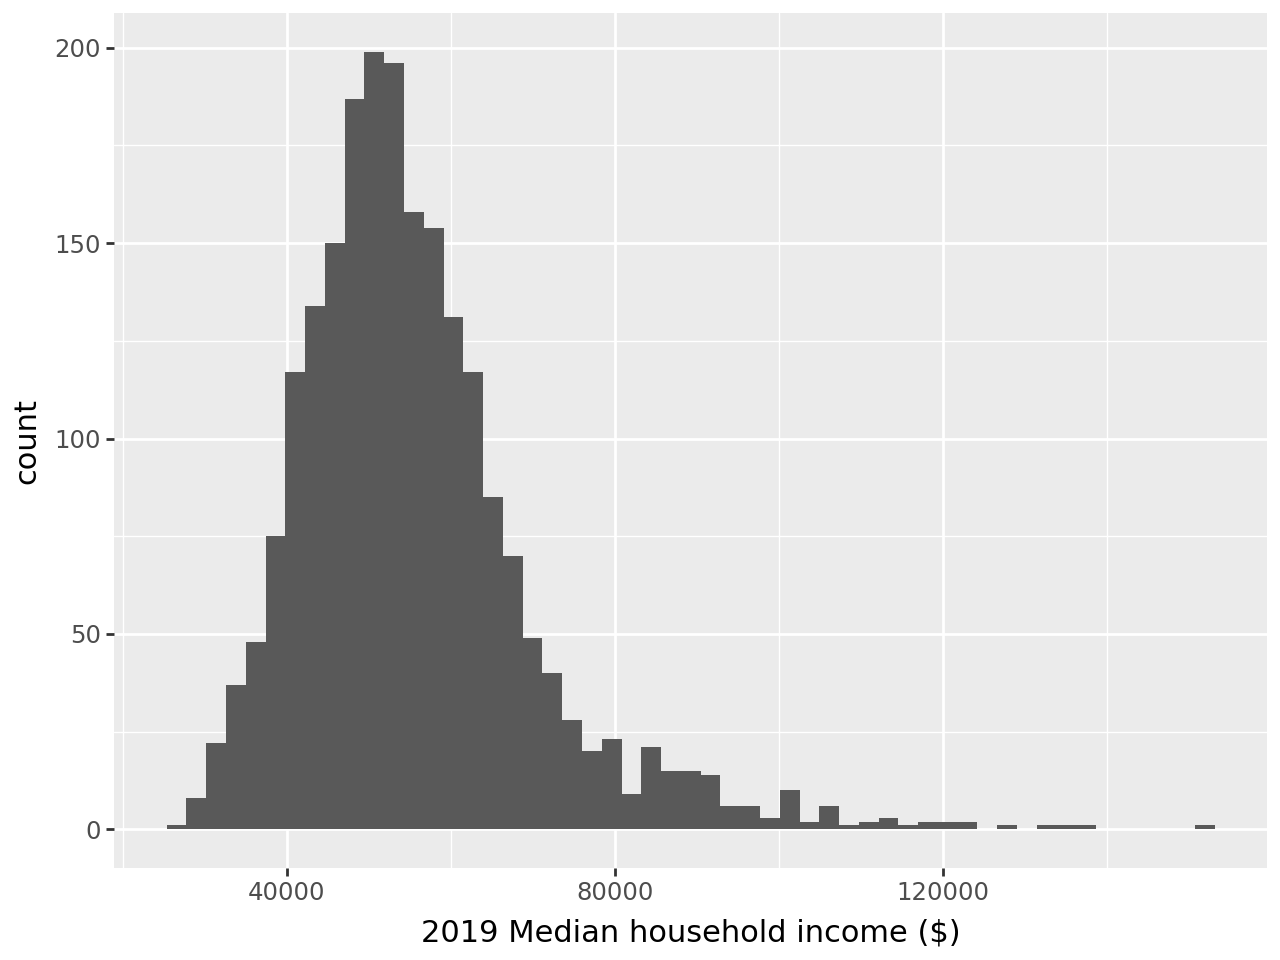

In [31]:
# # Exercice 4: Split et normalisation:

from sklearn.model_selection import train_test_split

# # On sépare les données avant d'appliquer la standardisation et normalisation:
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(columns="winner"), df2["winner"], test_size=0.3
)

# # 4.1.Normalisation des variables et vérification sur Median_Household_Income_2019
scaler = preprocessing.Normalizer().fit(X_train)
X1 = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X2 = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

p1 = (
    p9.ggplot(X_train, p9.aes(x="Median_Household_Income_2019"))
    + p9.geom_histogram()
    + p9.labs(x="2019 Median household income ($)")
)
p2 = (
    p9.ggplot(X1, p9.aes(x="Median_Household_Income_2019"))
    + p9.geom_histogram()
    + p9.labs(x="2019 Median household income (normalized, training sample)")
)
p3 = (
    p9.ggplot(X2, p9.aes(x="Median_Household_Income_2019"))
    + p9.geom_histogram()
    + p9.labs(x="2019 Median household income (normalized, extrapolated sample)")
)
p1

C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 111'. Pick better value with 'binwidth'.


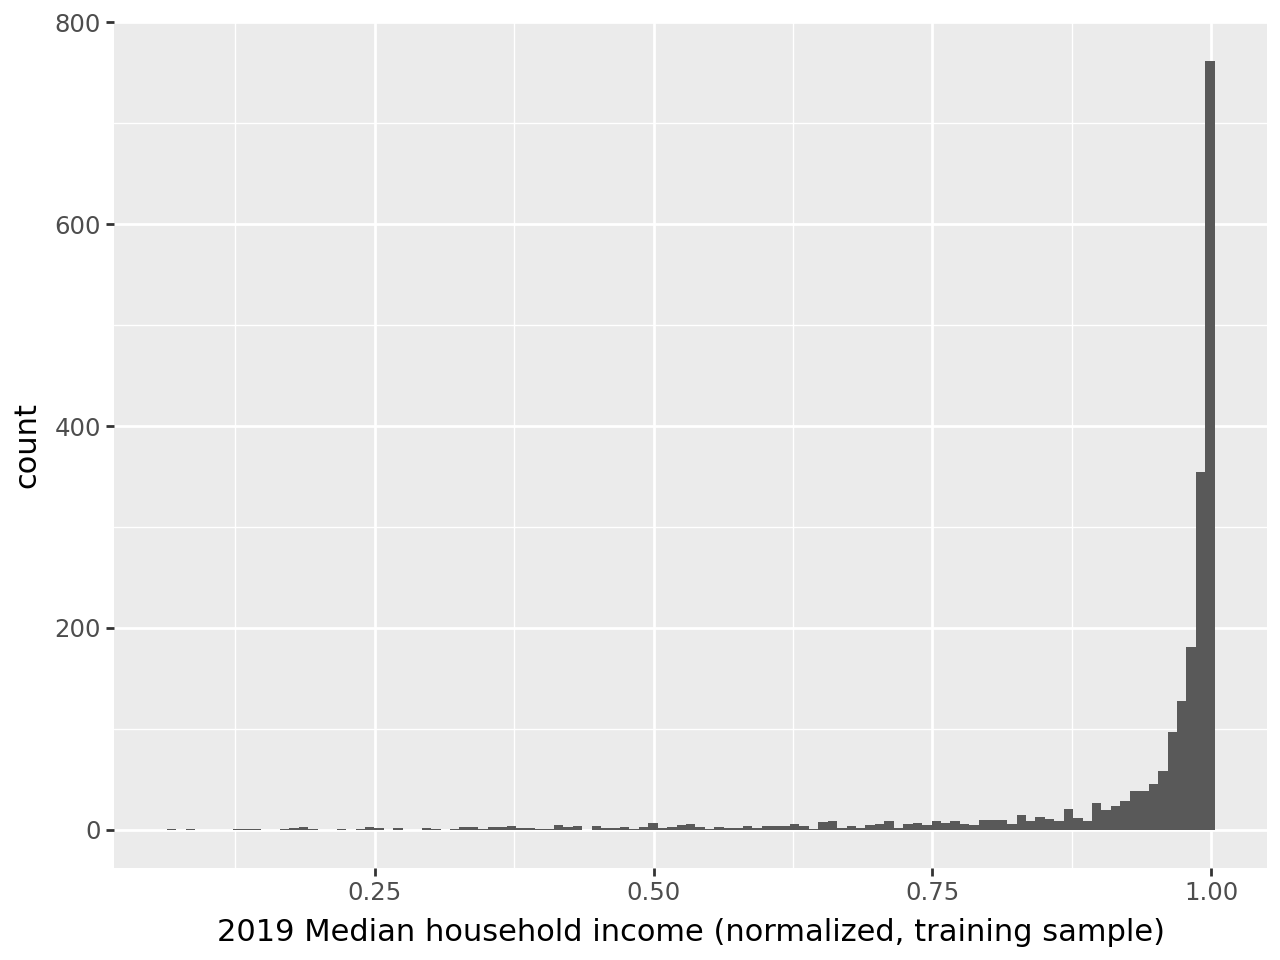

In [32]:
p2

C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 67'. Pick better value with 'binwidth'.


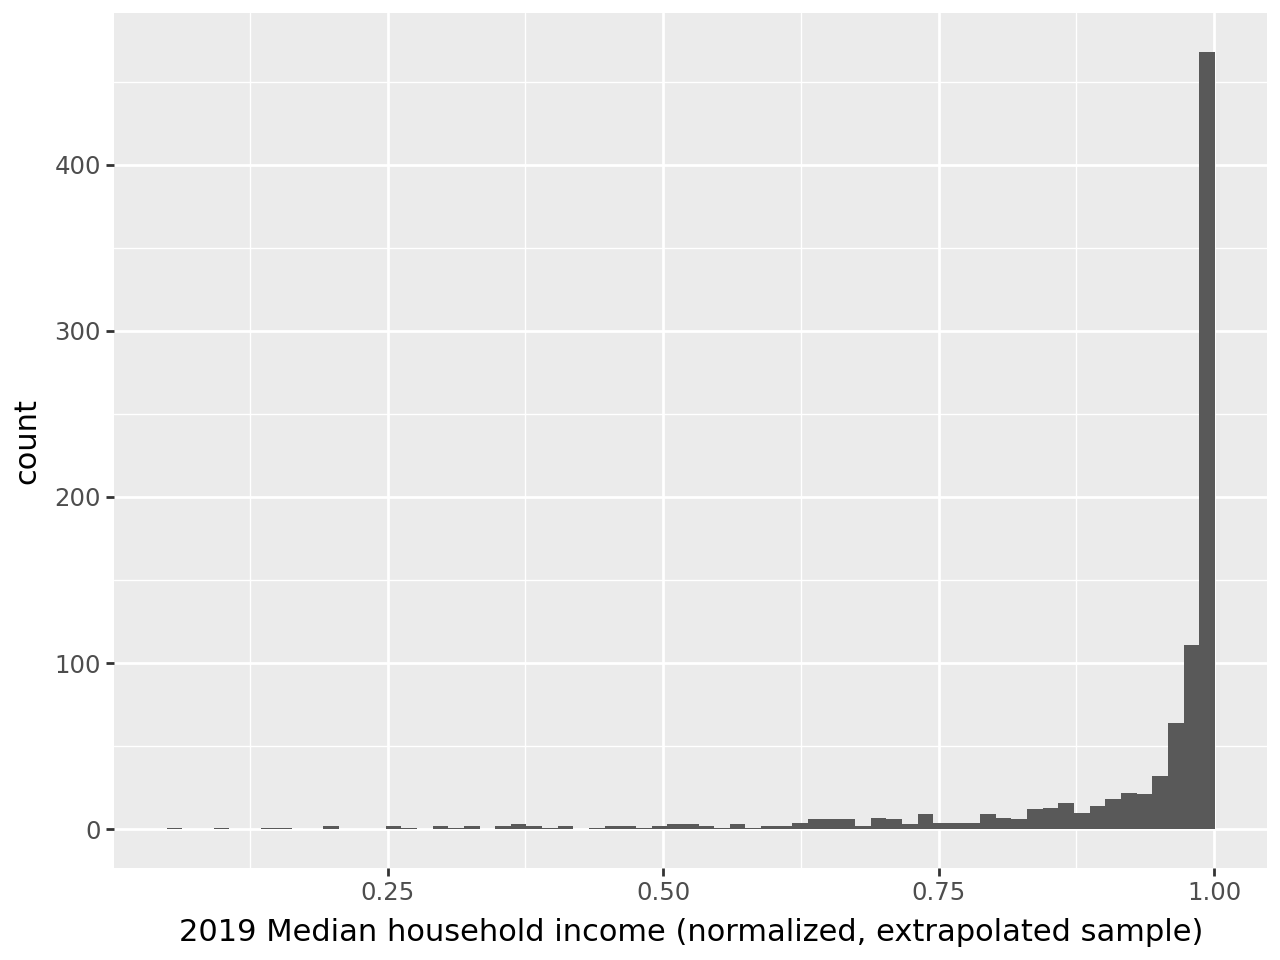

In [33]:
p3

In [34]:
# # 4.3. Vérification de la norme L2
pd.DataFrame(
    {
        "X_train_norm2": np.linalg.norm(X1.head(10), axis=1),
        "X_test_norm2": np.linalg.norm(X2.head(10), axis=1),
    }
).head(5)

X_train_norm2  X_test_norm2
0            1.0           1.0
1            1.0           1.0
2            1.0           1.0
3            1.0           1.0
4            1.0           1.0

In [36]:
# # 4.2 Exemple encodage valeurs catégorielles

from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# Exemple de données catégoriques
data = pd.DataFrame({
    'couleur': ['rouge', 'bleu', 'vert', 'rouge', 'bleu'],
    'taille': ['petit', 'grand', 'moyen', 'petit', 'moyen']
})

# Initialisation du OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Transformation
encoded_data = ordinal_encoder.fit_transform(data)

print("Données encodées :")
print(encoded_data)

print("Mapping des catégories :")
for i, categories in enumerate(ordinal_encoder.categories_):
    print(f"Feature {data.columns[i]} : {categories}")


Données encodées :
[[1. 2.]
 [0. 0.]
 [2. 1.]
 [1. 2.]
 [0. 1.]]
Mapping des catégories :
Feature couleur : ['bleu' 'rouge' 'vert']
Feature taille : ['grand' 'moyen' 'petit']


In [37]:
# # 4.3 Exemple imputation
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Exemple de dataset avec valeurs manquantes
data = pd.DataFrame({
    'Age': [25, 30, np.nan, 35, 40],
    'Salaire': [50000, np.nan, 60000, 70000, np.nan],
    'Sexe': ['M', 'F', 'M', np.nan, 'F']
})
# Initialisation du SimpleImputer avec la stratégie "mean"
imputer_mean = SimpleImputer(strategy='mean')

# Imputation des colonnes numériques
data[['Age', 'Salaire']] = imputer_mean.fit_transform(data[['Age', 'Salaire']])

print("\nDonnées après imputation des colonnes numériques (moyenne) :")
print(data)


Données après imputation des colonnes numériques (moyenne) :
    Age  Salaire Sexe
0  25.0  50000.0    M
1  30.0  60000.0    F
2  32.5  60000.0    M
3  35.0  70000.0  NaN
4  40.0  60000.0    F


In [39]:
# # 4.4 Exemple détection outliers:
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

# Exemple de données
data = pd.DataFrame({
    'Feature1': [1, 2, 2, 3, 4, 5, 100],
    'Feature2': [1, 1, 2, 2, 3, 4, 100]
})

print("Données originales :")
print(data)

# Initialisation de l'Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)

# Ajustement sur les données
iso_forest.fit(data)

# Prédictions : -1 pour les anomalies, 1 pour les points normaux
predictions = iso_forest.predict(data)

# Score d'anomalie
anomaly_scores = iso_forest.decision_function(data)

# Ajouter les résultats au dataframe
data['Anomaly'] = predictions
data['Anomaly_Score'] = anomaly_scores

print("\nRésultats après détection des anomalies :")
print(data)


Données originales :
   Feature1  Feature2
0         1         1
1         2         1
2         2         2
3         3         2
4         4         3
5         5         4
6       100       100

Résultats après détection des anomalies :
   Feature1  Feature2  Anomaly  Anomaly_Score
0         1         1        1       0.179492
1         2         1        1       0.222783
2         2         2        1       0.229702
3         3         2        1       0.228740
4         4         3        1       0.188927
5         5         4        1       0.110478
6       100       100       -1      -0.165716


In [41]:
# # Exercice 5: Encoder les variables catégorielles

# # 5.1. Création de df
df = votes.loc[:, ["state_name", "county_name"]]

# # 5.2. Appliquer un LabelEncoder à stat_name
label_enc = preprocessing.LabelEncoder().fit(df["state_name"])
np.column_stack((label_enc.transform(df["state_name"]), df["state_name"]))

# # 5.3. dummy expansion de state_name
display(pd.get_dummies(df["state_name"]))

# # 5.4. OrdinalEncoder
ord_enc = preprocessing.OrdinalEncoder().fit(df)
# ord_enc.transform(df[['state', 'county']])
ord_enc.transform(df)[:, 0]

# # 5.5. OneHotEncoder
onehot_enc = preprocessing.OneHotEncoder().fit(df)
onehot_enc.transform(df)

Alabama  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  \
0       False    False     False       False     False        False     False   
1       False    False     False       False     False        False     False   
2       False    False     False       False     False        False     False   
3       False    False     False       False     False        False     False   
4       False    False     False       False     False        False     False   
...       ...      ...       ...         ...       ...          ...       ...   
3102    False    False     False       False     False        False     False   
3103    False    False     False       False     False        False     False   
3104    False    False     False       False     False        False     False   
3105    False    False     False       False     False        False     False   
3106    False    False     False       False     False        False     False   

      District of Columbia  Florida  Georgia  ...  South Dakota  Tennessee  \
0                    False    False    False  ...         False      False   
1                    False    False    False  ...         False      False   
2                    False    False    False  ...         False      False   
3                    False    False    False  ...         False      False   
4                    False    False    False  ...         False       True   
...                    ...      ...      ...  ...           ...        ...   
3102                 False    False    False  ...         False      False   
3103                 False    False    False  ...         False      False   
3104                 False    False    False  ...         False      False   
3105                 False    False    False  ...         False      False   
3106                 False    False    False  ...         False      False   

      Texas   Utah  Vermont  Virginia  Washington  West Virginia  Wisconsin  \
0     False  False    False     False       False          False      False   
1     False  False    False     False       False          False      False   
2     False  False    False     False       False          False      False   
3     False  False    False     False       False          False      False   
4     False  False    False     False       False          False      False   
...     ...    ...      ...       ...         ...            ...        ...   
3102  False  False    False     False       False          False      False   
3103  False  False    False     False       False          False      False   
3104   True  False    False     False       False          False      False   
3105   True  False    False     False       False          False      False   
3106   True  False    False     False       False          False      False   

      Wyoming  
0       False  
1       False  
2       False  
3       False  
4       False  
...       ...  
3102    False  
3103    False  
3104    False  
3105    False  
3106    False  

[3107 rows x 49 columns]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6214 stored elements and shape (3107, 1891)>